In [1]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

In [14]:
dp_mix_stan = """
data {
    int<lower=1> N;
    int<lower=1> T;
    
    vector[N*T] y;
    
    int<lower=1> p;
    
    vector[p+1]     mu_0;
    matrix[p+1,p+1] Sigma_0;
    
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    int<lower=1> H;
    
    int<lower=1>  ngrid;
    vector[ngrid] xgrid;
    
    matrix[N*T,p+1] X;
}

parameters {
    real<lower=0> alpha;
    matrix[p+1,H] betas;
    real<lower=0> sigma2;

    vector<lower=0,upper=1>[H-1] nus;
}

transformed parameters {
    real<lower=0> sigma = sqrt(sigma2);
    
    simplex[H] ws;
    
    vector<lower=0, upper=1>[H-1] cumprod_one_mv;
    cumprod_one_mv = exp(cumulative_sum(log1m(nus)));
    
    ws[1] = nus[1];
    ws[2:(H-1)] = nus[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    ws[H] = cumprod_one_mv[H-1];
}

model {
    alpha  ~ gamma(a_alpha, b_alpha);
    nus    ~ beta(1,alpha);
    sigma2 ~ inv_gamma(a_sigma2, b_sigma2);
    
    for (h in 1:H) {
        betas[1:p+1,h] ~ multi_normal(mu_0, Sigma_0);
    }
    
    for (i in 1:N*T) {
        vector[H] log_probas;
        for (h in 1:H) {
            log_probas[h] = log(ws[h]) + normal_lpdf(y[i] | dot_product(X[i,1:p+1],betas[1:p+1,h]), sigma);
        }
        target += log_sum_exp(log_probas);
    }
}

generated quantities {
    vector[N*T] s;
    
    for (i in 1:N*T) {
        vector[H] log_probas;
        for (h in 1:H) {
            log_probas[h] = log(ws[h]) + normal_lpdf(y[i] | dot_product(X[i,1:p+1],betas[1:p+1,h]), sigma);
        }
        s[i] = categorical_rng(softmax(log_probas));
    }
    
    vector[ngrid] dens;
    
     for (i in 1:ngrid) {
        vector[H] log_probas;
        for (h in 1:H) {
            log_probas[h] = log(ws[h]) + normal_lpdf(xgrid[i] | dot_product(X[i,1:p+1],betas[1:p+1,h]), sigma);
        }
        dens[i] =  exp(log_sum_exp(log_probas));
    }
}

"""

stan_file = "dirichlet.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dpm_stan = CmdStanModel(stan_file=stan_file)

14:32:20 - cmdstanpy - INFO - compiling stan file /home/daan/bayesian-project/dirichlet.stan to exe file /home/daan/bayesian-project/dirichlet
14:32:36 - cmdstanpy - INFO - compiled model executable: /home/daan/bayesian-project/dirichlet


In [15]:
## generate some data

ndata = 100
means = np.array([-5, 0, 5])
true_clus = np.random.choice(np.arange(3), size=ndata)

data = np.random.normal(loc=means[true_clus])

mu_0 = np.array([1,1,1,1])
Sigma_0 = np.eye(4)
X = np.zeros((100,4))

for i in range(100):
    X[i,:] = np.array([1,2,3,4])
    
xgrid = np.linspace(-10,10,100);

stan_data = {
    "N": 10,
    "T": 10,
    "p": 3,
    "y": data,
    "H": 10,
    "mu_0": mu_0,
    "Sigma_0" : Sigma_0,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "ngrid":len(xgrid),
    "xgrid": xgrid,
    "X": X    
}

fit = dpm_stan.sample(stan_data)

14:32:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:33:17 - cmdstanpy - INFO - CmdStan done processing.
14:33:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is inf, but must be positive finite! (in '/home/daan/bayesian-project/dirichlet.stan', line 50, column 4 to column 27)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in '/home/daan/bayesian-project/dirichlet.stan', line 50, column 4 to column 27)
Consider re-running with show_console=True if the above output is unclear!


/home/daan/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


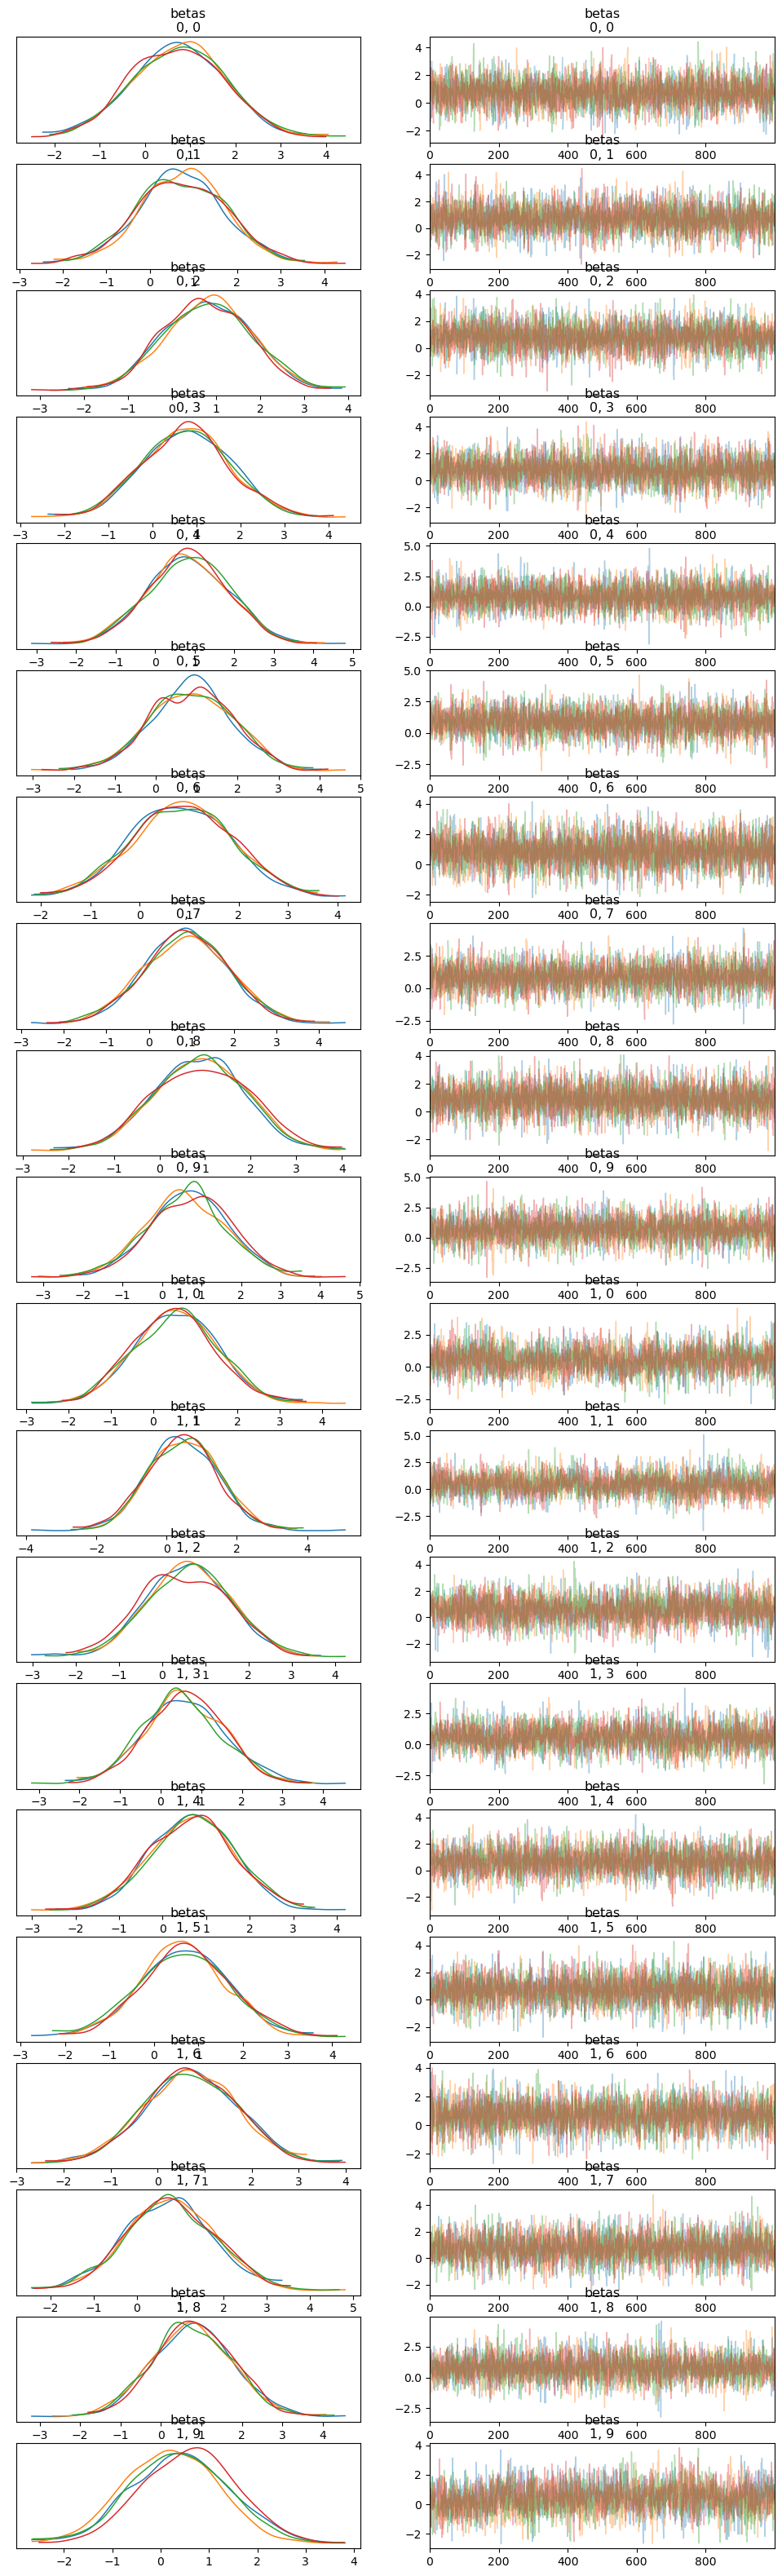

In [11]:
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()